In [42]:
# !pip install mne

In [43]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

from tqdm import tqdm

In [48]:
train_subjects = fetch_data(subjects=[0, 1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16], recording=[1])
raw_train, annotations_train = [], []
for i, subj in enumerate(train_subjects): 
  raw_train.append(mne.io.read_raw_edf(subj[0], stim_channel='marker', misc=['rectal']))
  annotations_train.append(mne.read_annotations(subj[1]))
  raw_train[i].set_annotations(annotations_train[i], emit_warning=False)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


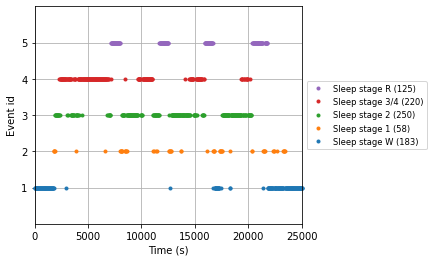

<Figure size 432x288 with 0 Axes>

In [97]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
for i, annot_train in enumerate(annotations_train):
  annotations_train[i].crop(annot_train[1]['onset'] - 30 * 60,
                  annot_train[-2]['onset'] + 30 * 60)
  raw_train[i].set_annotations(annot_train, emit_warning=False)

  events_train, _ = mne.events_from_annotations(
      raw_train[i], event_id=annotation_desc_2_event_id, chunk_duration=30.)

  # create a new event_id that unifies stages 3 and 4
  event_id = {'Sleep stage W': 1,
              'Sleep stage 1': 2,
              'Sleep stage 2': 3,
              'Sleep stage 3/4': 4,
              'Sleep stage R': 5}

  # plot events
  fig = mne.viz.plot_events(events_train, event_id=event_id,
                            sfreq=raw_train[i].info['sfreq'],
                            first_samp=events_train[0, 0])

  # keep the color-code for further plotting
  stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.savefig("events.png")

0it [00:00, ?it/s]

Not setting metadata
Not setting metadata
836 matching events found
No baseline correction applied
0 projection items activated
Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 183 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


1it [00:07,  7.27s/it]


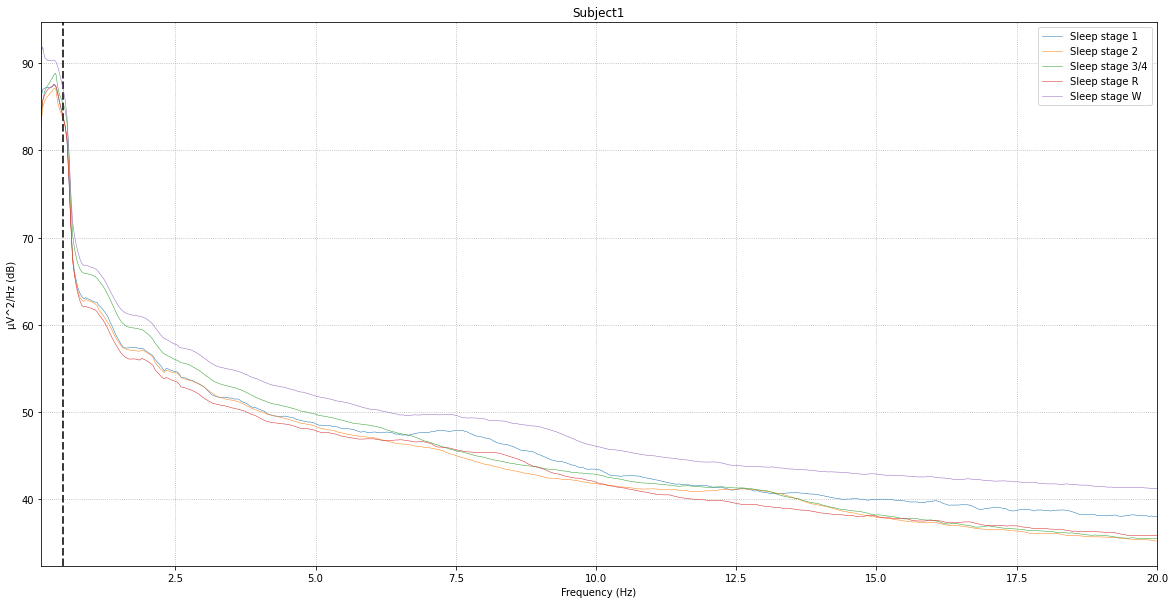

<Figure size 432x288 with 0 Axes>

In [98]:
fig, axs = plt.subplots(figsize=(20, 10))
epochs_train_lst = []
for i, raw in tqdm(enumerate(raw_train)):
  tmax = 30. - 1. / raw.info['sfreq']  # tmax in included

  epochs_train = mne.Epochs(raw=raw, events=events_train,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None)
  epochs_train_lst.append(epochs_train)
  stages = sorted(event_id.keys())

  for stage, color in zip(stages, stage_colors):
    epochs_train[stage].plot_psd(area_mode=None, color=color, ax=axs,
                          fmin=0.1, fmax=20., show=False,
                          average=True, spatial_colors=False)
    axs.set(title="Subject1", xlabel='Frequency (Hz)')

  axs.set(ylabel='µV^2/Hz (dB)')
  axs.legend(axs.lines[2::3], stages)

plt.show()
plt.savefig("energy.png")


In [94]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [95]:
test_subject1, test_subject2 = fetch_data(subjects=[18, 20], recording=[1])

raw_test = mne.io.read_raw_edf(test_subject1[0], stim_channel='marker', misc=['rectal'])

annotations_test = mne.read_annotations(test_subject1[1])
raw_test.set_annotations(annotations_test, emit_warning=False)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4181E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<RawEDF | SC4181E0-PSG.edf, 7 x 8268000 (82680.0 s), ~12 kB, data not loaded>

In [96]:
raw_test = mne.io.read_raw_edf(test_subject1[0], stim_channel='marker',
                               misc=['rectal'])
annot_test = mne.read_annotations(test_subject1[1])
annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                annot_test[-2]['onset'] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.)
epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

print(epochs_test)

Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4181E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
964 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  964 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 29
 'Sleep stage 2': 388
 'Sleep stage 3/4': 291
 'Sleep stage R': 118
 'Sleep stage W': 138>


In [81]:
%%time
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

# Train
epochs_train_concat = mne.concatenate_epochs(epochs_train_lst)
y_train = epochs_train_concat.events[:, 2]
pipe.fit(epochs_train_concat, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Loading data for 841 events and 3000 original time points ...
Not setting metadata
Not setting metadata
841 matching events found
No baseline correction applied
0 bad epochs dropped
Effective window size : 2.560 (s)
Loading data for 964 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Accuracy score: 0.745850622406639
CPU times: user 14 s, sys: 176 ms, total: 14.2 s
Wall time: 14.9 s


In [84]:
print(confusion_matrix(y_test, y_pred))

import pandas as pd
pd.DataFrame(confusion_matrix(y_test, y_pred))

[[128   9   0   0   1]
 [ 12  13   0   0   4]
 [ 11  28 264  36  49]
 [  5   2  41 243   0]
 [ 13  14  20   0  71]]


,0,1,2,3,4
0,128,9,0,0,1
1,12,13,0,0,4
2,11,28,264,36,49
3,5,2,41,243,0
4,13,14,20,0,71


In [85]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

                 precision    recall  f1-score   support

  Sleep stage W       0.76      0.93      0.83       138
  Sleep stage 1       0.20      0.45      0.27        29
  Sleep stage 2       0.81      0.68      0.74       388
Sleep stage 3/4       0.87      0.84      0.85       291
  Sleep stage R       0.57      0.60      0.58       118

       accuracy                           0.75       964
      macro avg       0.64      0.70      0.66       964
   weighted avg       0.77      0.75      0.75       964

